# KNN Pulsar Classification

# Introduction

Pulsars are rotating neutron stars with beam-like radio emissions. Properties such as rotation give pulsars distinct emissions, which could be measured by radio telescopes on Earth. However, due to the abundance of radio frequency interference (RFI) and noise, distinguishing real pulsar signals from spurious ones is a challenging task. As such, astronomers often employ data-driven techniques to facilitate pulsar detection. A group of astronomy students gained access to a dataset containing a massive amount of radio emissions data. This dataset contains several statistics—mean, standard deviation, excess kurtosis, and skew—from the integrated profile and DM-SNR of numerous observations. The integrated profile is the combined emission curve over several measurements, whereas DM-SNR describes the amount of dispersive smearing and noise present in a signal. ***Given these 8 candidate predictor variables, the students aim to investigate whether it is possible to identify and predict real vs. spurious pulsar observations to a reasonable degree.***

# Methods & Results

Loading libraries necessary for this project.

In [1]:
install.packages("themis")

library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(ggplot2)
library(themis)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0     ✔ recipes   0.2.0
✔ dials     0.0.9     ✔ rsample   0.0.7
✔ infer     0.5.4     ✔ tune      0.1.1
✔ modeldata 0.0.2     ✔ workflows 0.2.0
✔ parsnip   0.1.3     ✔ yards

Setting random generation seed for reproducibility.  
The seed number is an arbitrary choice.

In [2]:
set.seed(1234)

## Loading Data

Downloading and reading data from the source on the web.  
Pulsar HTRU2 dataset from https://archive.ics.uci.edu/ml/datasets/HTRU2.
  
 
The dataset zip file is downloaded from the URL link, then unzipped into the data folder. 

In [3]:
# create a data folder
dir.create('data')
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, destfile = "data/HTRU_2.zip")
# unzip data zip into the data folder
unzip('data/HTRU_2.zip',exdir='data')

The downloaded data is in the CSV format, with a delimiter of ',', so the default read_csv() function was used to load the data.   
Since column names were not specified in the CSV file, they are thus named by the col_names parameter.  
The Class variable was converted to the factor datatype to facilitate KNN classification.

In [4]:
# read data csv, name columns, then change class labels into factors
pulsar <- read_csv("data/HTRU_2.csv", col_names = c("Mean_IP", "SD_IP", "EK_IP", "Skew_IP", "Mean_DM_SNR", "SD_DM_SNR", "EK_DM_SNR", "Skew_DM_SNR", "Class")) %>%
        mutate(Class = as_factor(Class))

Parsed with column specification:
cols(
  Mean_IP = col_double(),
  SD_IP = col_double(),
  EK_IP = col_double(),
  Skew_IP = col_double(),
  Mean_DM_SNR = col_double(),
  SD_DM_SNR = col_double(),
  EK_DM_SNR = col_double(),
  Skew_DM_SNR = col_double(),
  Class = col_double()
)



In [5]:
'Table 1. Pulsar dataset'
pulsar

[1] "Table 1. Pulsar dataset"

Mean_IP,SD_IP,EK_IP,Skew_IP,Mean_DM_SNR,SD_DM_SNR,EK_DM_SNR,Skew_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


## Exploratory Data Analysis

The following is an investigation of missing data in the pulsar dataset.    
Since the dataset is in the appropriate format with no missing entries, the wrangling and cleaning process is thus complete.  

In [6]:
# examine the training set for missing data
pulsar_na <- sum(is.na(pulsar))
pulsar_na

[1] 0

The loaded pulsar dataset is split into training and testing sets.  
The 75% training and 25% testing split is mostly arbitrary since it is a commonly used splitting ratio that balances training resources and evaluation accuracy.

In [7]:
# split dataset into training/testing 75/25
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

As shown in Table 2, the following investigation of the proportions of real versus spurious observations showed that the ratio is almost 9:1. Therefore, there exists an imbalance in the dataset.
The variable count n shows that the training dataset contains a sizable number of observations. Consequently, the training process might be computationally taxing.

As shown in Table 3, the mean, minimum, and maximum of each column/predictor vary significantly in magnitude. Therefore, scaling and centering is necessary since we have to compute Euclidean distance during KNN classification.

In [8]:
# find the number of samples & prop of each class in the training set
pulsar_proportions_train <- pulsar_train %>%
                      group_by(Class) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(pulsar_train))


pulsar_means_train_all <- pulsar_train %>%
                      select(-Class) %>%
                      map_df(mean, na.rm  = TRUE) %>%
                      mutate(Stat = 'mean')

pulsar_min_train_all <- pulsar_train %>%
                      select(-Class) %>%
                      map_df(min, na.rm  = TRUE) %>%
                      mutate(Stat = 'min')

pulsar_max_train_all <- pulsar_train %>%
                      select(-Class) %>%
                      map_df(max, na.rm  = TRUE) %>%
                      mutate(Stat = 'max')

pulsar_stats <- full_join(pulsar_means_train_all, pulsar_min_train_all) %>% full_join(pulsar_max_train_all)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = c("Mean_IP", "SD_IP", "EK_IP", "Skew_IP", "Mean_DM_SNR", "SD_DM_SNR", "EK_DM_SNR", "Skew_DM_SNR", "Stat")

Joining, by = c("Mean_IP", "SD_IP", "EK_IP", "Skew_IP", "Mean_DM_SNR", "SD_DM_SNR", "EK_DM_SNR", "Skew_DM_SNR", "Stat")



In [9]:
'Table 2. Training data proportions and count'
pulsar_proportions_train

'Table 3. Training data summary table'
pulsar_stats

[1] "Table 2. Training data proportions and count"

Class,n,percent
<fct>,<int>,<dbl>
0,12207,90.934148
1,1217,9.065852


[1] "Table 3. Training data summary table"

Mean_IP,SD_IP,EK_IP,Skew_IP,Mean_DM_SNR,SD_DM_SNR,EK_DM_SNR,Skew_DM_SNR,Stat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
111.1618,46.58549,0.4732306,1.736118,12.4824474,26.153751,8.338479,105.720940,mean
5.8125,24.77204,-1.7380208,-1.791886,0.2132107,7.370432,-3.139270,-1.976976,min
190.4219,98.77891,8.0695220,68.101622,223.3921405,110.642211,34.539844,1191.000837,max


A recipe is created for the training data for the KNN classification process.  
The data is scaled and centered to account for any problems when computing Euclidean distance during KNN classification.  
Due to the class imbalance, oversampling is also applied to the process in order to shift the likelihood/ratio close to 1:1.

A processed version of the dataset is also created using the recipe.

In [10]:
# center and scale training data
knn_recipe <- recipe(Class ~ Mean_IP + SD_IP + EK_IP + Skew_IP + Mean_DM_SNR + SD_DM_SNR + EK_DM_SNR + Skew_DM_SNR, data = pulsar_train) %>%
                       themis::step_upsample(Class, over_ratio = 1) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors()) 

# convered centered and scaled 
train_scaled <- knn_recipe %>%  
                   prep() %>% 
                   bake(pulsar_train)

In [11]:
'Table 4. Training data after scaling and centering'
train_scaled

[1] "Table 4. Training data after scaling and centering"

Mean_IP,SD_IP,EK_IP,Skew_IP,Mean_DM_SNR,SD_DM_SNR,EK_DM_SNR,Skew_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.3962214,1.5002537,-0.9579956,-0.6869579,-0.6224816,-0.8369933,0.4380558,0.07618348,0
0.4065493,1.8828807,-0.6023440,-0.6720618,-0.6593087,-1.0102328,0.9754522,0.61581598,0
0.4197558,-0.4546165,-0.6744966,-0.5456478,-0.6243826,-0.7296228,0.3885281,-0.03621068,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.8441912,2.008903,-0.7578163,-0.6904589,-0.1815279,0.7836705,-0.6933713,-0.6309257,0
0.7186282,1.287162,-0.7365763,-0.6324892,-0.6527967,-1.0704923,0.8579876,0.6853149,0
-0.7753276,5.102482,-0.1241340,-0.6232632,3.8547435,1.0217291,-1.5398822,-0.6630663,0


The following is a visualization of the training data. It visualizes the relationships between all predictor variables using scatter plots, box plots, histograms, and correlation. The scatterplots and correlation provide a visual representation of the statistical relationship and dependencies between predictors, as well as class distributions. The boxplots visualized the spread and centers of each predictor according to class. Since the classes in the boxplots of several predictor pairs do not overlap, distinguishing between real versus spurious observations should be feasible. In addition, the class imbalance is visually evident given the histograms and the bar chart. 

The scaled and centered version of the training data was used to better represent the class partitions.  

Among the predictors, it appears that the Integrated Profile μ and Integrated Profile Excess Kurtosis might have the greatest contribution to prediction accuracy since their clusters are fairly well defined. From clustering behavior alone, we can expect that most predictors will be relevant, except for DM-SNR Skewness or DM-SNR Excess Kurtosis.

In [12]:
options(repr.plot.width = 34, repr.plot.height = 20)
# duplicate dataframe
train_scaled_dup <- data.frame(train_scaled)
# rename columns names for plotting
colnames(train_scaled_dup) <- c('Integrated Profile\nμ','Integrated Profile\nσ','Integrated Profile\nExcess Kurtosis', 'Integrated Profile\nSkewness','DM-SNR\nμ','DM-SNR\nσ','DM-SNR\nExcess Kurtosis','DM-SNR\nSkewness', 'Class')
sum_plots <- ggpairs(train_scaled_dup, aes(color = Class, alpha = 0.5), title = 'Figure 1. Summary Plots') 

[1] "Figure 1. Summary Plots"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



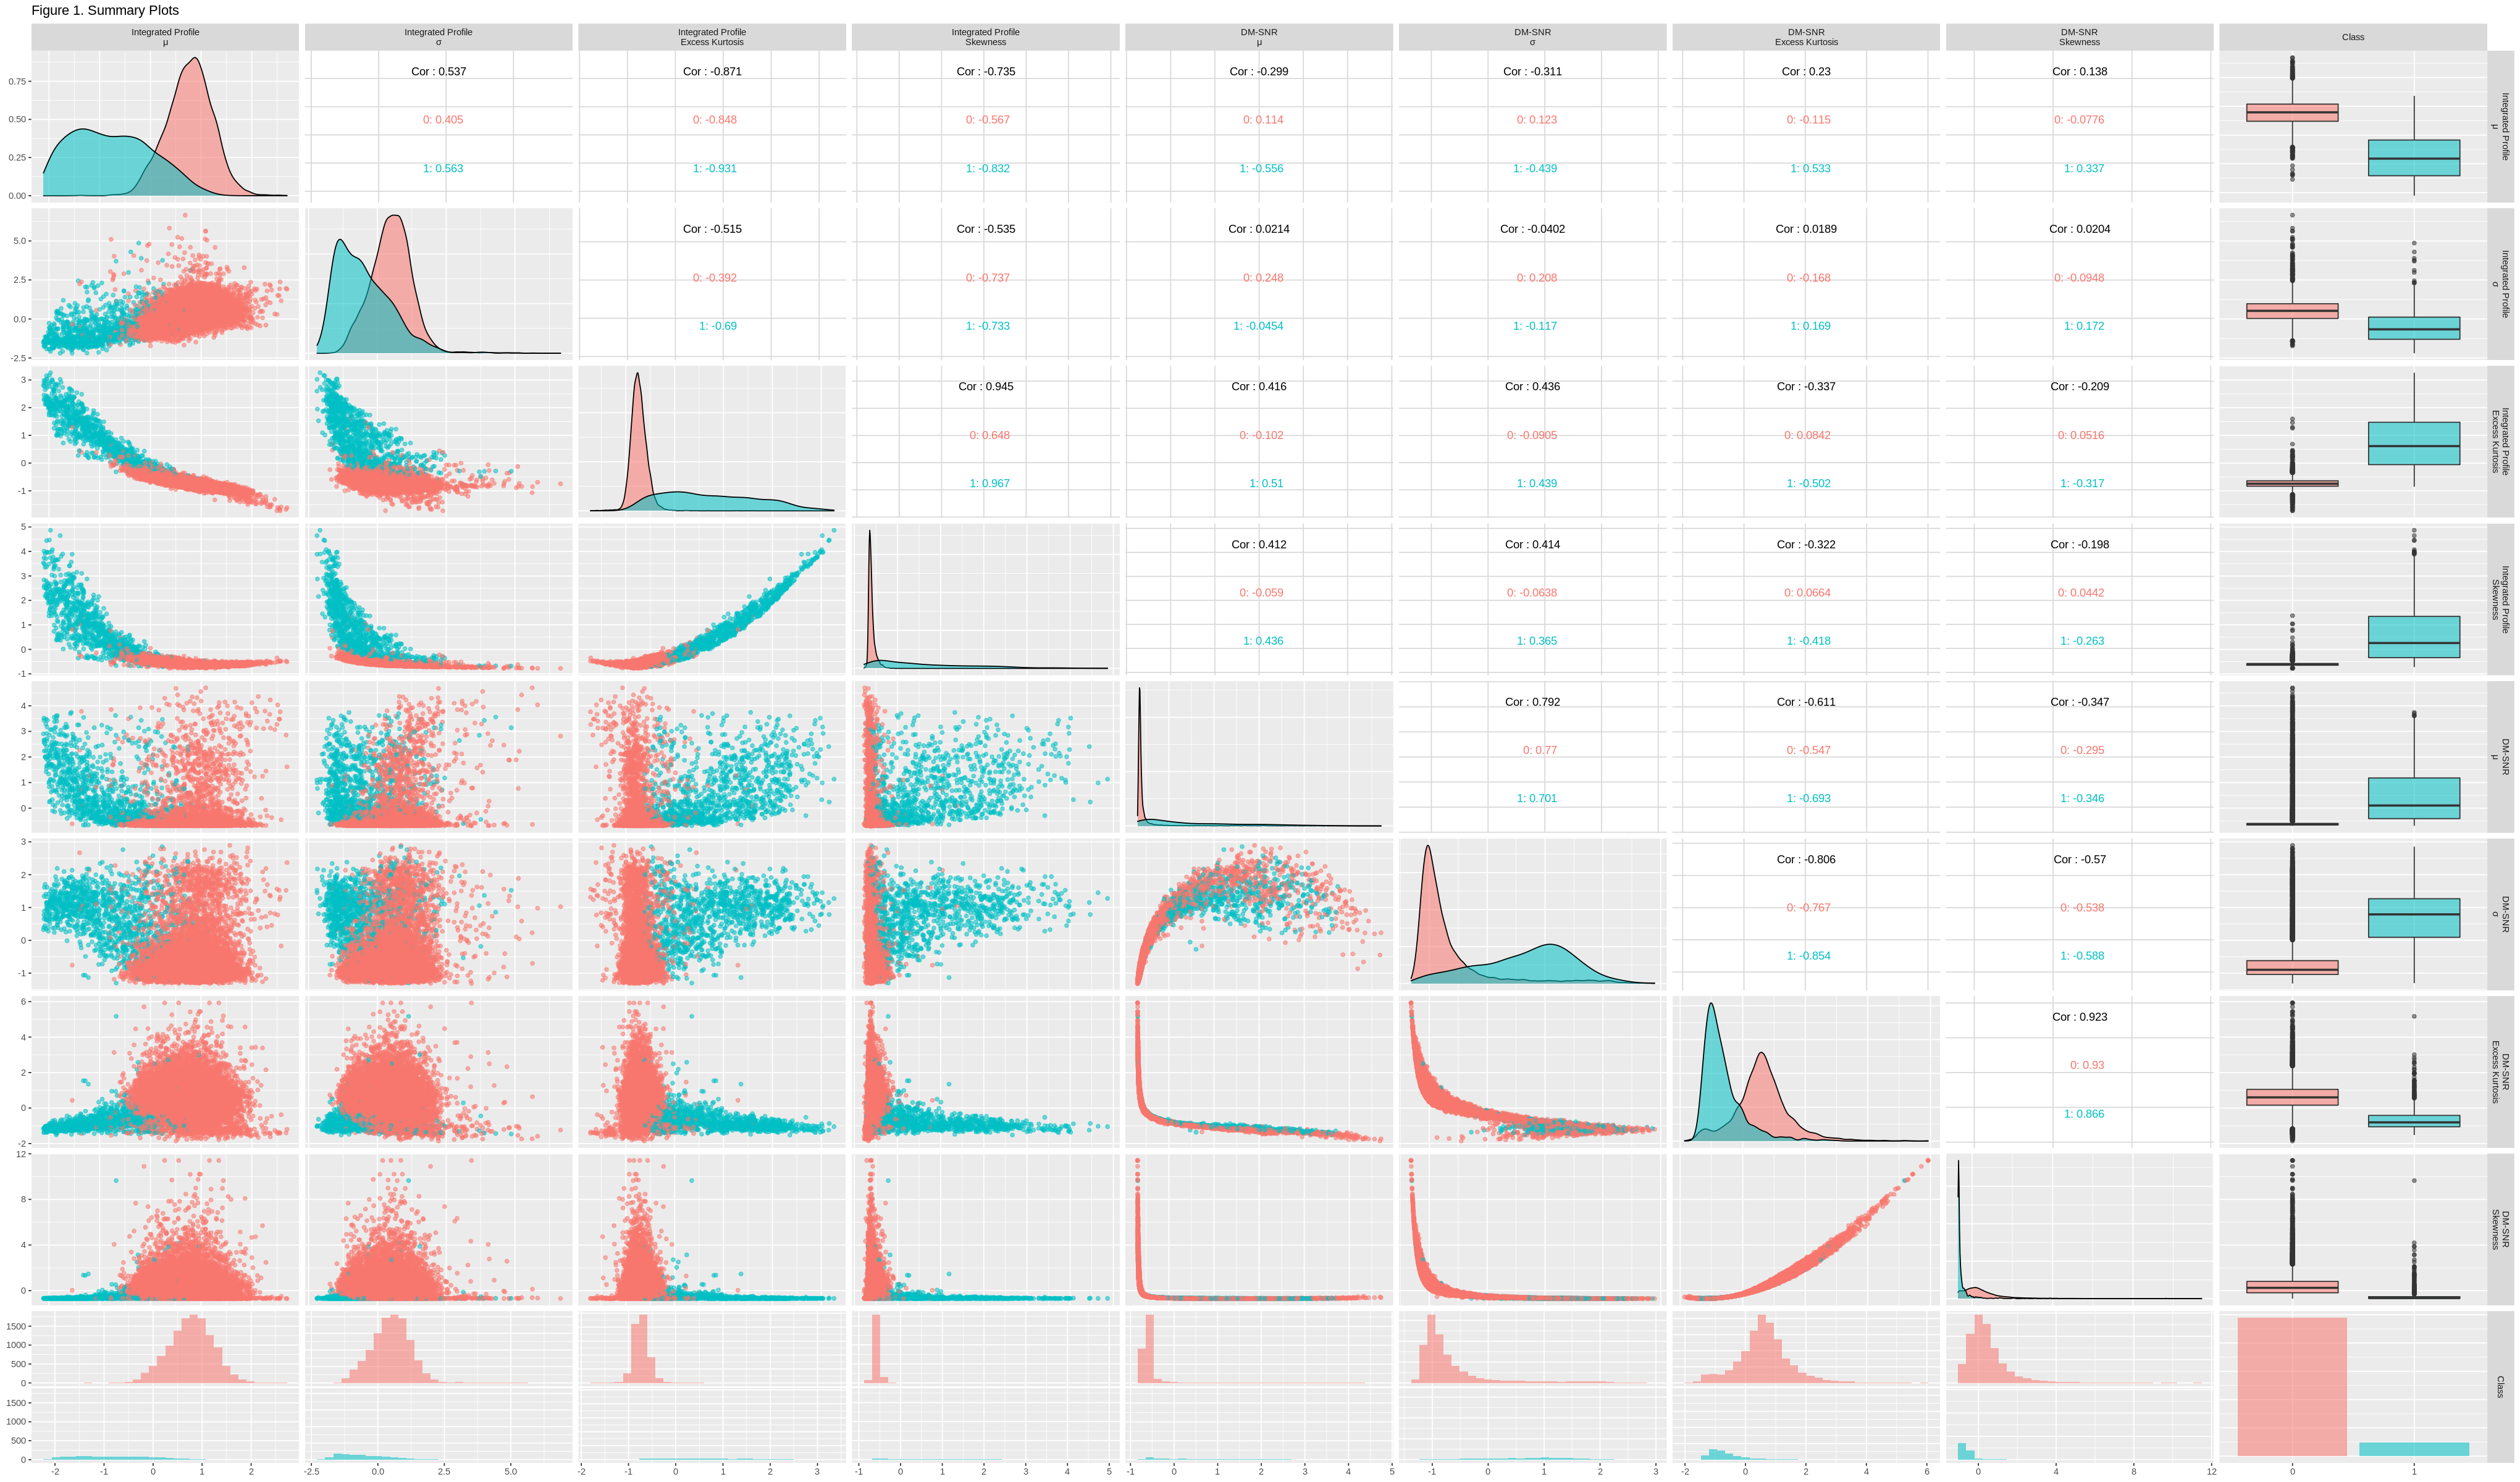

In [14]:
'Figure 1. Summary Plots'
sum_plots

## Predictor Variable Selection

First, we start building the KNN model by investigating the relevancy of candidate predictors. Since the statistics of emissions data cannot be analyzed manually, it is not immediately obvious which predictors will be relevant for KNN classification. Although we have hypothesized certain predictors will not contribute significantly to the classification process during exploratory data analysis, a more objective method for evaluating predictor relevancy is preferable. Since irrelevant predictors might decrease the model’s accuracy, irrelevant predictors should be discarded. In addition, the results of predictor variable selection will also confirm our expectations from the earlier exploratory data analysis. In order to identify irrelevant predictors under reasonable computing costs, forward selection was chosen as the technique for finding a suitable subset of predictors.  

The results of forward selection are displayed in Table 5. The contents are sorted according to model accuracy. Overall, the accuracies of models built from predictor subsets do not fluctuate significantly in magnitude, where the lowest is around 94.89% and the highest is around 97.08%. The difference in performance for the two most accurate subsets (6: 97.08% and 5: 97.07%) is almost negligible at 0.01%. We decided to proceed with the model with fewer parameters to reduce overall computing costs. As expected from the exploratory data analysis, DM-SNR Skewness and DM-SNR Excess Kurtosis could be considered irrelevant as they have little or negative contributions to the models’ accuracies.

In [15]:
names <- colnames(pulsar_train %>% select(-Class))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# creates the cross-validation folds 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = Class)

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_train) %>%
                          step_upsample(Class, over_ratio = 1) %>% 
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(pulsar_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = pulsar_vfold, grid = 5) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [16]:
'Table 5. Forward selection predictor subset estimated accuracies'
accuracies %>% arrange(desc(accuracy))

[1] "Table 5. Forward selection predictor subset estimated accuracies"

size,model_string,accuracy
<int>,<chr>,<dbl>
6,Class ~ EK_IP+SD_DM_SNR+SD_IP+Mean_DM_SNR+Mean_IP+Skew_DM_SNR,0.9708731
5,Class ~ EK_IP+SD_DM_SNR+SD_IP+Mean_DM_SNR+Mean_IP,0.9707244
4,Class ~ EK_IP+SD_DM_SNR+SD_IP+Mean_DM_SNR,0.9700539
⋮,⋮,⋮
7,Class ~ EK_IP+SD_DM_SNR+SD_IP+Mean_DM_SNR+Mean_IP+Skew_DM_SNR+EK_DM_SNR,0.9625298
8,Class ~ EK_IP+SD_DM_SNR+SD_IP+Mean_DM_SNR+Mean_IP+Skew_DM_SNR+EK_DM_SNR+Skew_IP,0.9624554
1,Class ~ EK_IP,0.9489715


The estimated accuracies for subsets of predictors are shown in Figure 2. 1 predictor produced the lowest accuracy. We can observe a sizable improvement when the size of the subset is greater than 2. Models with more than 5 predictors performed mostly the same since certain columns have less relevance to the classification.

[1] "Figure 2. Forward selection estimated accuracy vs. the number of predictors"

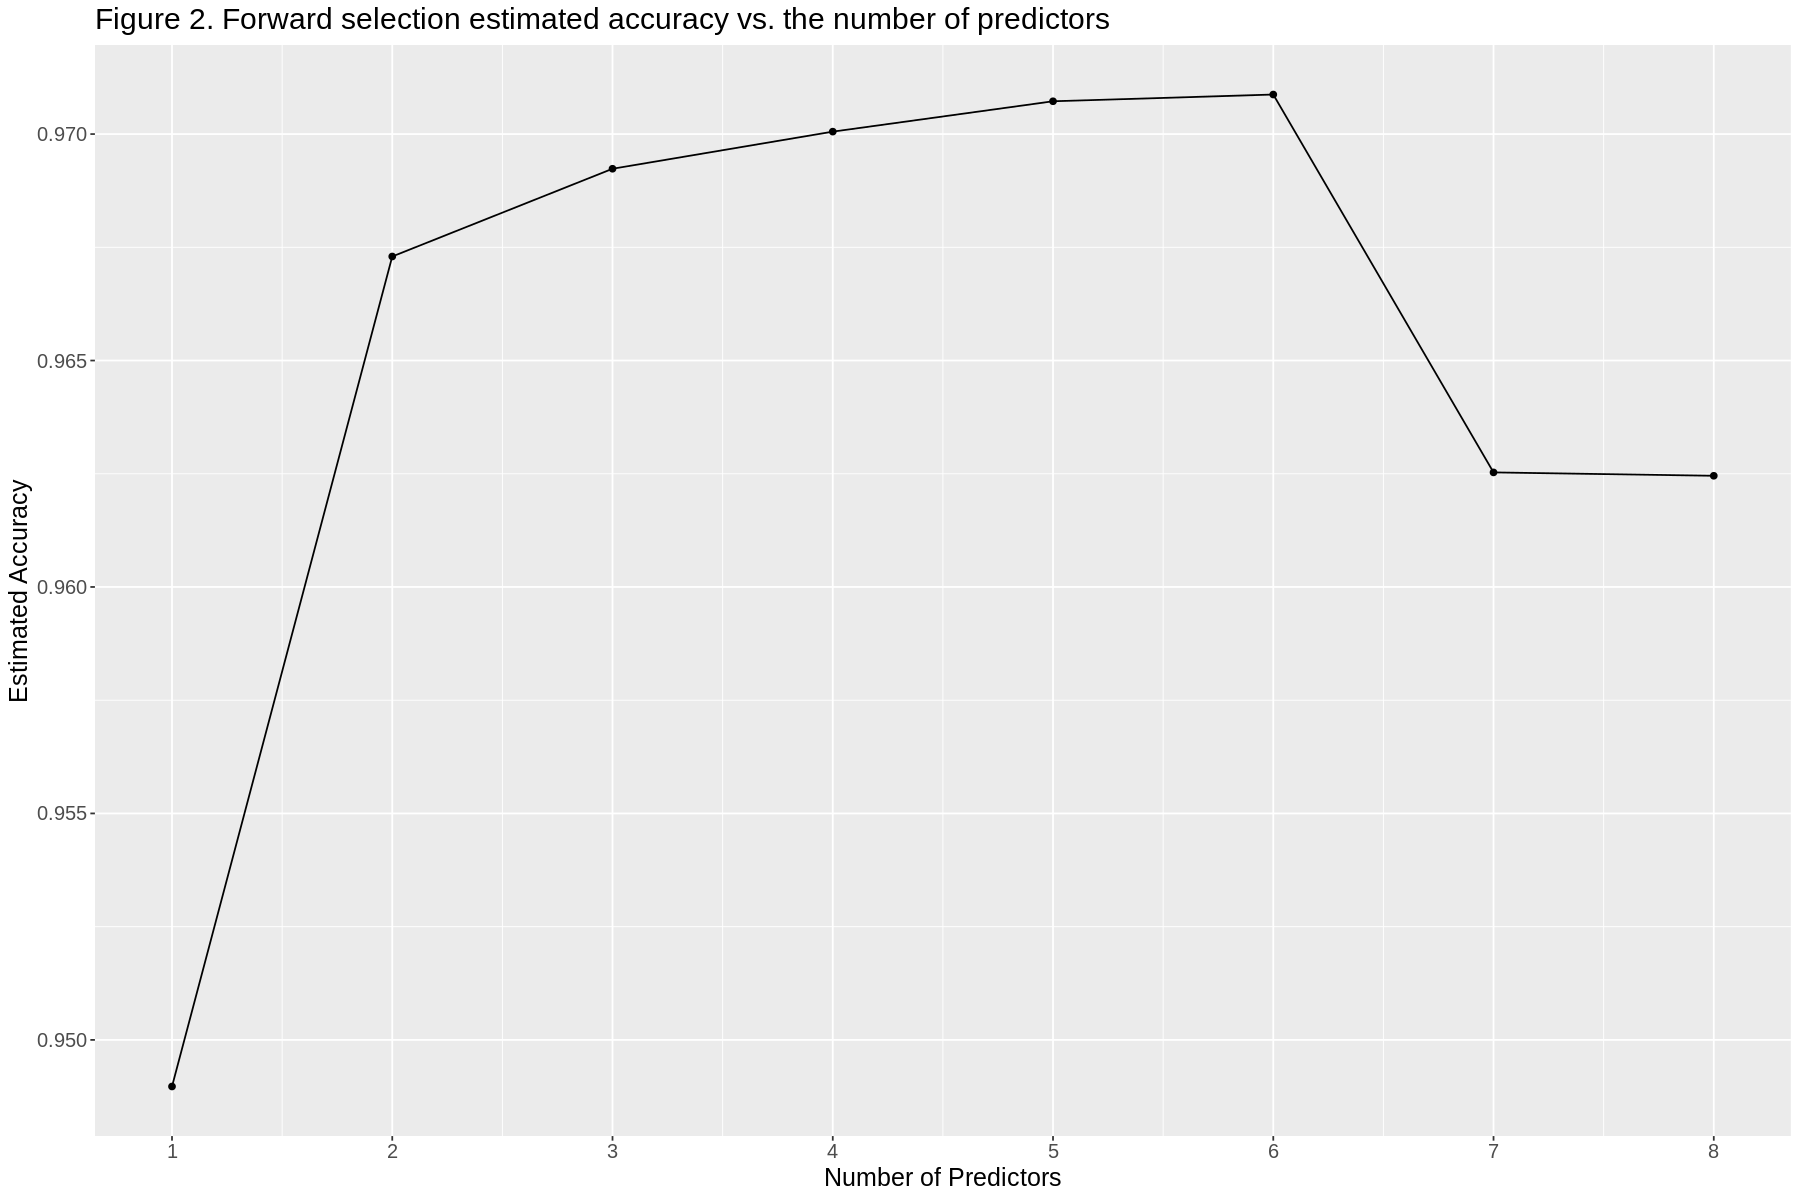

In [17]:
options(repr.plot.width = 15, repr.plot.height = 10)

# plot the accuracies for each K value
accuracy_vs_p <- ggplot(accuracies, aes(x = size, y = accuracy)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Predictors", y = "Estimated Accuracy") + 
  scale_x_continuous(breaks = seq(1, 10, by = 1)) +
  theme(text = element_text(size = 15)) +
  ggtitle("Figure 2. Forward selection estimated accuracy vs. the number of predictors")

"Figure 2. Forward selection estimated accuracy vs. the number of predictors"
accuracy_vs_p

## Hyperparameter K Selection

Since we have identified a suitable subset of relevant predictors for pulsar prediction, in order to initiate our KNN classification analysis, we start by performing 5-fold cross-validation on the training set. Cross-validation was chosen since measures with the most statistical confidence are preferable for building the most accurate model possible. The number of folds was chosen arbitrarily.  

A relatively broad range of K parameter values was chosen to investigate model performance. Since the dataset contains an abundant number of observations, it is expected that the model should not overfit even with K values in the hundreds range. In consideration of the computing costs, we decided to perform a preliminary parameter selection using K values from 1 to 200, with a step size of 10. Although not the most specific, these K values should provide us with a basic understanding of the effects of the hyperparameter on accuracy.



In [18]:
# center and scale training data
knn_recipe <- recipe(Class ~ EK_IP + SD_DM_SNR + SD_IP + Mean_DM_SNR + Mean_IP, data = pulsar_train) %>%
                       step_upsample(Class, over_ratio = 1) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors()) 

# creates the cross-validation folds 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = Class)

# creates the KNN model
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

# table of steps for K from 1 to 100 with a step size of 10
k_vals <- tibble(neighbors = seq(from = 1, to = 200, by = 10))

# perform knn classification with different K, then collect metrics
knn_results <- workflow() %>%
                  add_recipe(knn_recipe) %>%
                  add_model(knn_spec) %>%
                  tune_grid(resamples = pulsar_vfold, grid = k_vals)%>%
                  collect_metrics() %>%
                  filter(.metric == "accuracy")

In [19]:
'Table 6. KNN performance for K values'
knn_results

[1] "Table 6. KNN performance for K values"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9683403,5,0.001398204,Model01
11,accuracy,binary,0.9281150,5,0.004565322,Model02
21,accuracy,binary,0.9322117,5,0.003460767,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
171,accuracy,binary,0.9570173,5,0.001972522,Model18
181,accuracy,binary,0.9573154,5,0.001716506,Model19
191,accuracy,binary,0.9573898,5,0.001625563,Model20


The results of K parameter value selection are shown in Table 6 and Figure 3. We can see that while using K=1 yielded the highest accuracy, model performance drops when using 11 or 21 neighbors. However, as K increases past 21, we can observe a gradual increase in model performance. For K values greater than around 100, increases in the estimated accuracy diminished significantly. It might be possible that using K = 1 inadvertently resulted in overfitting, where the model depended too much on the training data. Since the model’s performance stabilizes for K values greater than around 100, in consideration of computing costs, we decided to proceed with a smaller K ∈ [91, 101] for the rest of our analysis.

[1] "Figure 3. Parameter Value Selection Accuracy Estimate vs. Neighbors"

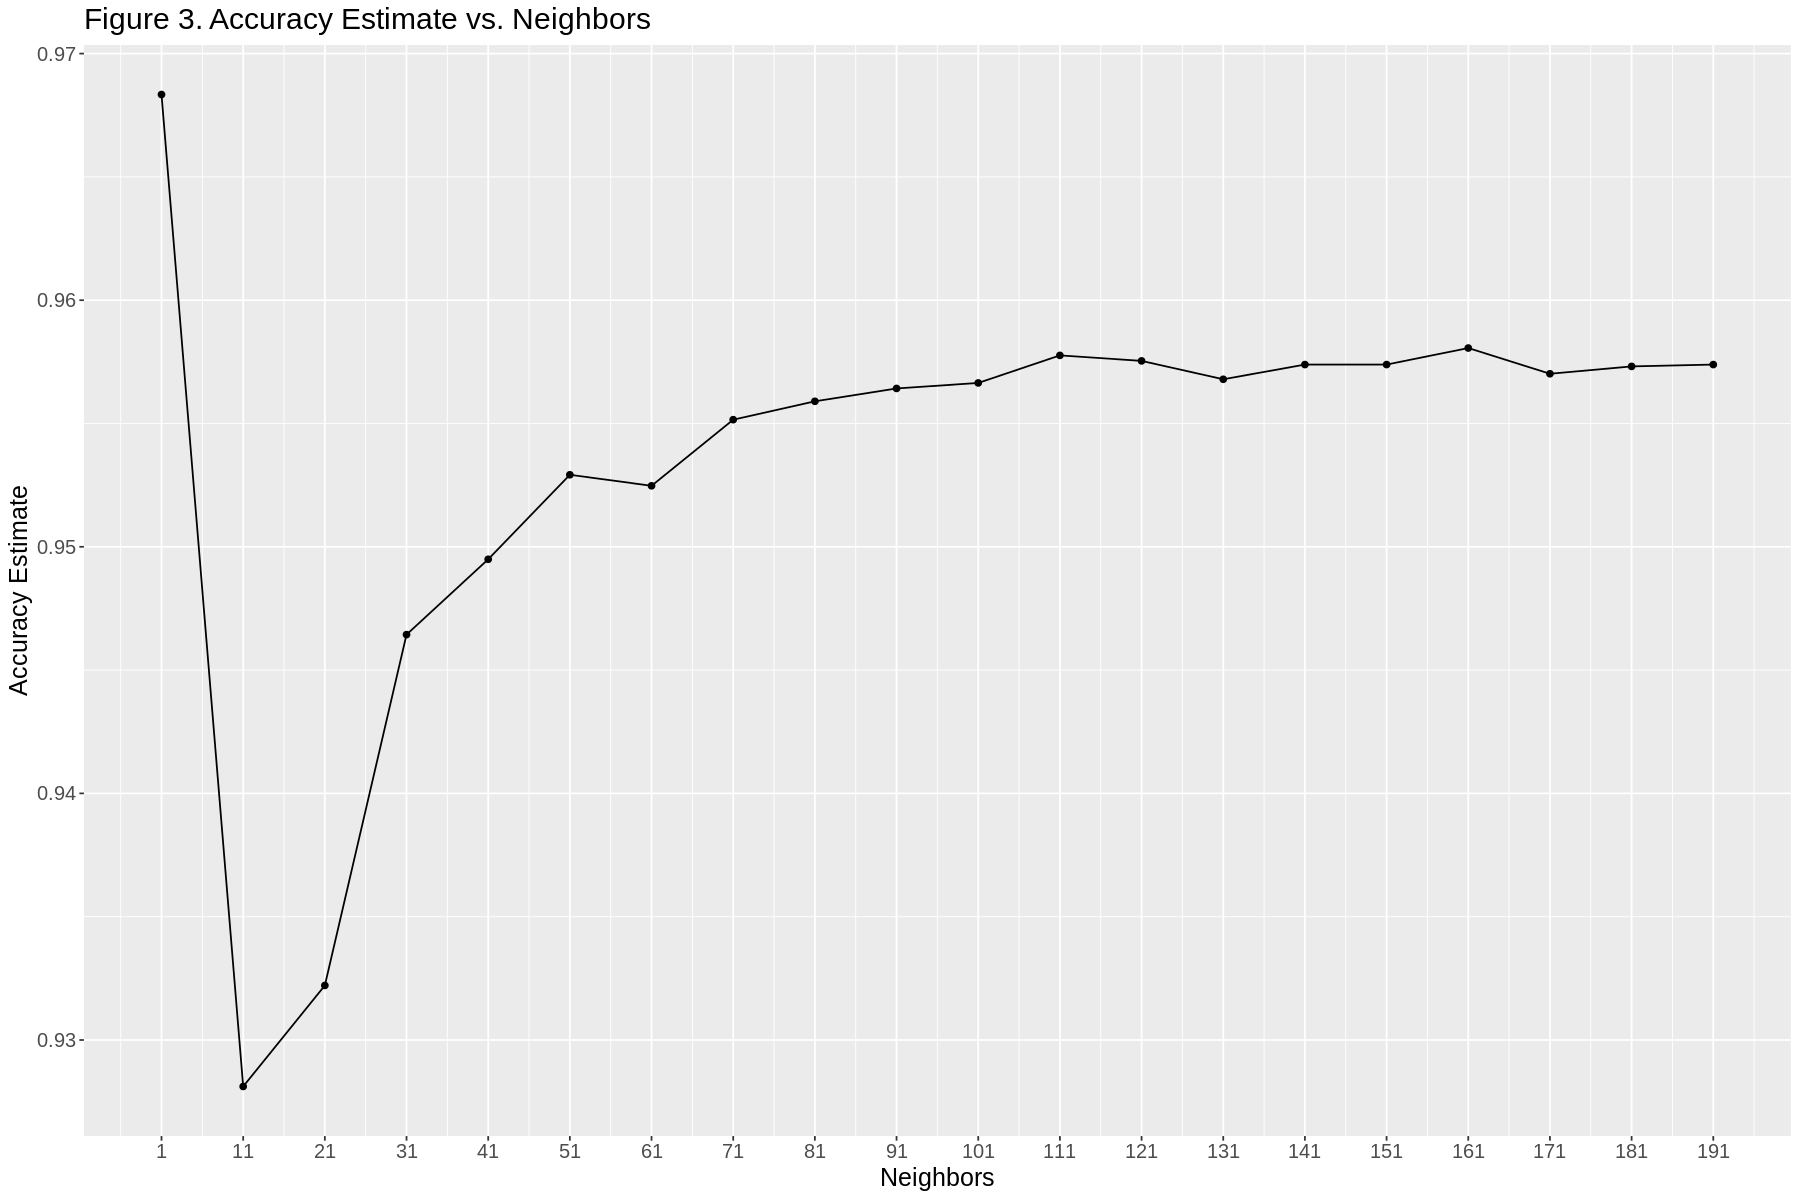

In [27]:
options(repr.plot.width = 15, repr.plot.height = 10)

# plot the accuracies for each K value
accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  scale_x_continuous(breaks = seq(1, 200, by = 10)) +
  theme(text = element_text(size = 15)) +
  ggtitle("Figure 3. Accuracy Estimate vs. Neighbors")
"Figure 3. Parameter Value Selection Accuracy Estimate vs. Neighbors"
accuracy_vs_k

We decided to further investigate the optimal K value for our pulsar classification model using smaller step sizes. 

In [21]:
# table of steps for K from 1 to 10 with a step size of 1
k_vals_2 <- tibble(neighbors = seq(from = 91, to = 101, by = 1))

# perform knn classification with different K, then collect metrics
knn_results_2 <- workflow() %>%
                  add_recipe(knn_recipe) %>%
                  add_model(knn_spec) %>%
                  tune_grid(resamples = pulsar_vfold, grid = k_vals_2)%>%
                  collect_metrics() %>%
                  filter(.metric == "accuracy")

In [22]:
'Table 7. KNN performance for K ∈ [91, 101]'
knn_results_2

[1] "Table 7. KNN performance for K ∈ [91, 101]"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
91,accuracy,binary,0.9564215,5,0.001865145,Model01
92,accuracy,binary,0.9564215,5,0.001865145,Model02
93,accuracy,binary,0.9561980,5,0.001979077,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,accuracy,binary,0.9561978,5,0.001788729,Model09
100,accuracy,binary,0.9561978,5,0.001788729,Model10
101,accuracy,binary,0.9566447,5,0.001944962,Model11


The results of the more detailed K parameter value selection are shown in Table 7 and Figure 4. Since K = 101 yielded the highest accuracy, we decided to select it as the hyperparameter value for our KNN pulsar classification model.

[1] "Figure 4. Parameter Value Selection Accuracy Estimate vs. Neighbors K [91, 101]"

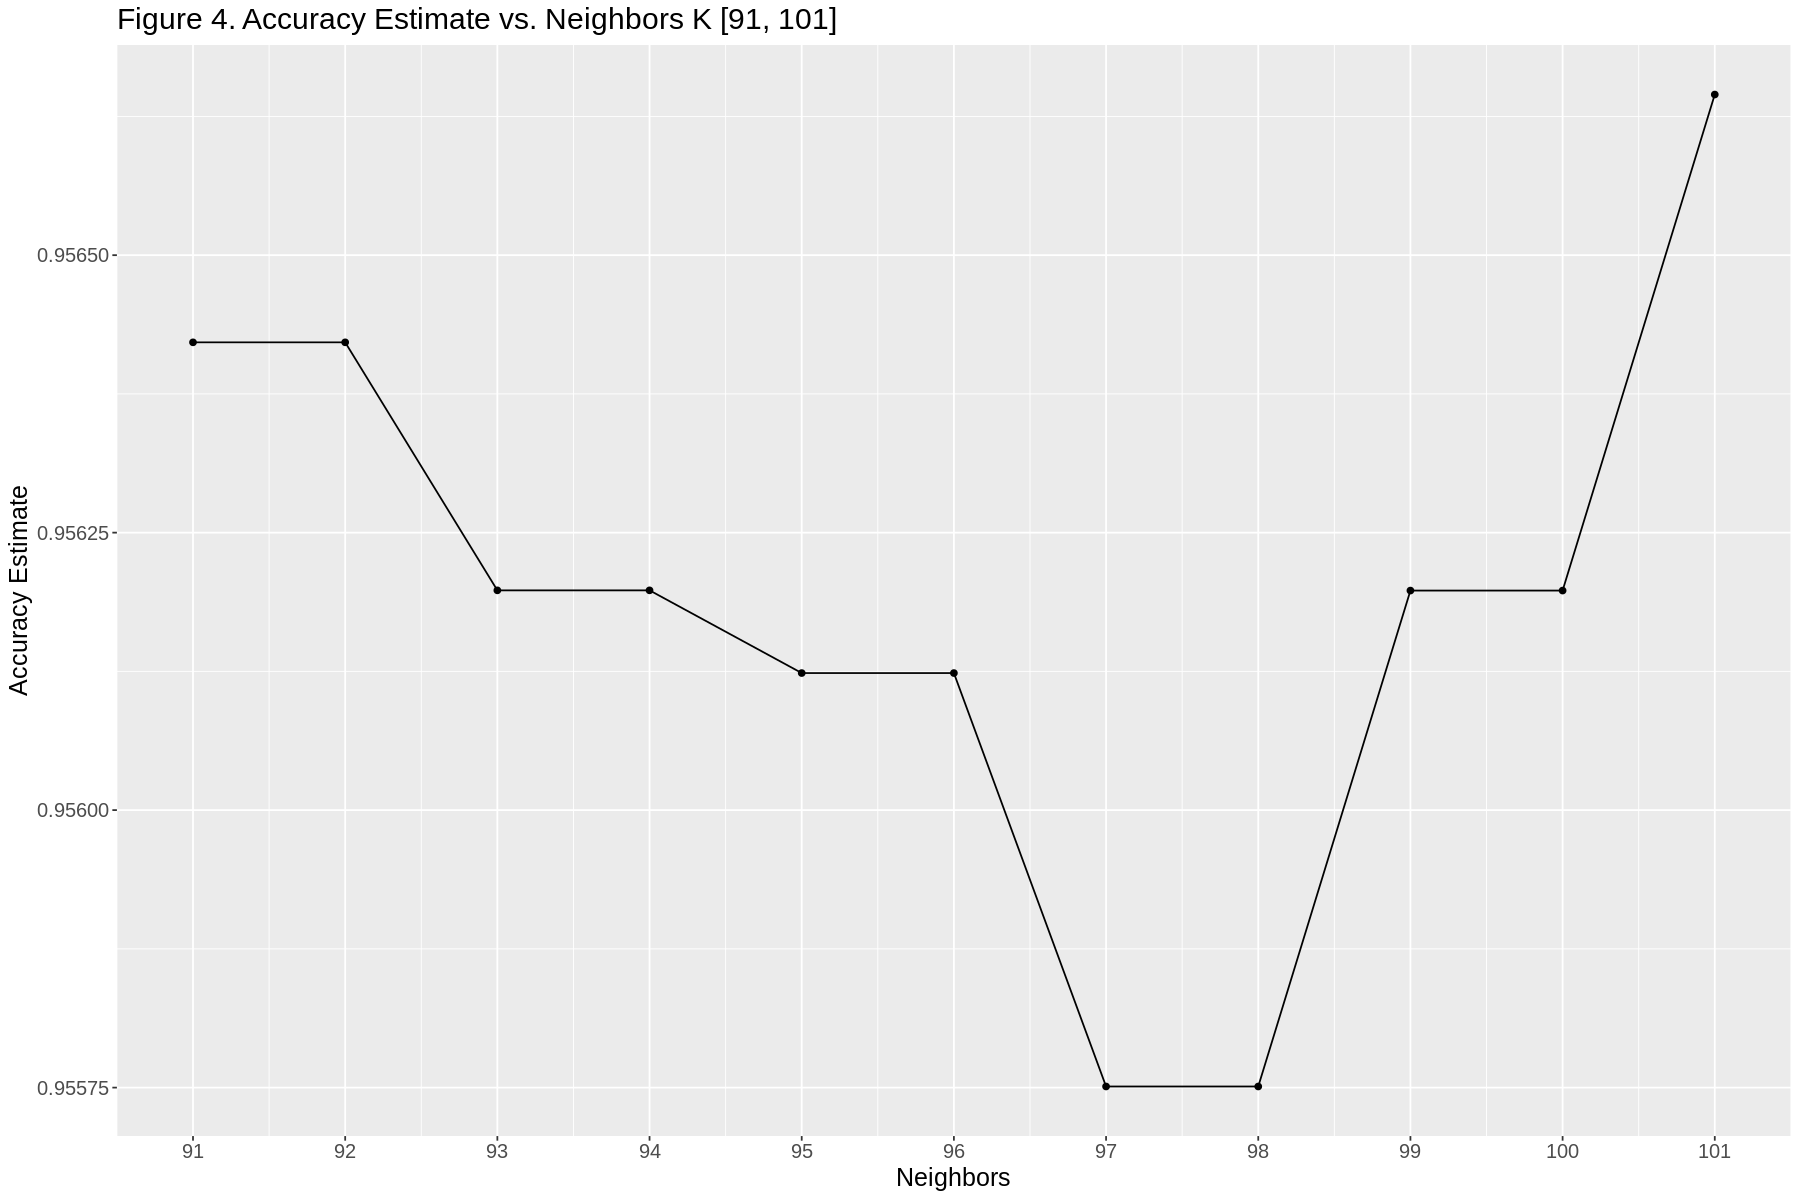

In [28]:
options(repr.plot.width = 15, repr.plot.height = 10)

# plot the accuracies for each K value
accuracy_vs_k_2 <- ggplot(knn_results_2, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  scale_x_continuous(breaks = seq(91, 101, by = 1)) +
  theme(text = element_text(size = 15)) +
  ggtitle("Figure 4. Accuracy Estimate vs. Neighbors K [91, 101]")
"Figure 4. Parameter Value Selection Accuracy Estimate vs. Neighbors K [91, 101]"
accuracy_vs_k_2

## Optimal Model Construction

Since we have identified the relevant predictors and the optimal hyperparameter K, we can now construct the KNN classification model and evaluate its performance using the test dataset. An accuracy measure of the model’s predictions on the test dataset was generated by comparing the predicted labels against true labels. In addition, a confusion matrix was also generated to illustrate the frequency of false-positive and false-negative predictions.

In [24]:
# create the knn model with best K
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 101) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# create knn model with non redundant predictors
# center, scale, oversample
knn_recipe <- recipe(Class ~ EK_IP + SD_DM_SNR + SD_IP + Mean_DM_SNR + Mean_IP, data = pulsar_train) %>%
                       step_upsample(Class, over_ratio = 1) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors()) 

# fit model with training data
knn_fit <- workflow() %>%
  add_recipe(knn_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = pulsar_train)

# predict using model on test data
pulsar_test_predictions <- predict(knn_fit, pulsar_test) %>%
  bind_cols(pulsar_test)

# generate confusion matrix
confusion <- pulsar_test_predictions %>%
             conf_mat(truth = Class, estimate = .pred_class)


# calculate accuracy
accuracy <- pulsar_test_predictions %>%
  metrics(truth = Class, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

In [25]:
'Table 8. Confusion matrix for K = 101'
confusion
'Table 9. Accuracy estimate for K = 101'
accuracy

[1] "Table 8. Confusion matrix for K = 101"

          Truth
Prediction    0    1
         0 3923   39
         1  129  383

[1] "Table 9. Accuracy estimate for K = 101"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9624497


As shown in Table 9, the accuracy of our KNN classification model is 96.24%. While the accuracy measure is high percentage-wise, it is not the most reliable measure of model performance due to the class imbalance in the pulsar dataset. Since it is nearly 9 times more likely for an observation to be spurious, we could obtain a high accuracy simply by always predicting ‘spurious’. Therefore, it is necessary to opt for a different measure to evaluate the model’s performance. The confusion matrix is a more suitable representation of the model’s ability to classify pulsars.  

The confusion matrix shows that a total of 383 (real) + 3923 (spurious) = 4306 observations were correctly labeled. However, the classifier also made a sizable number of mistakes. 129 observations were incorrectly labeled as real when they are in actuality spurious (false positive), while 39 observations were incorrectly labeled as spurious when they are in actuality real (false negative). 

[1] "Figure 5. Mosaic diagram and heatmap of the confusion matrix for K = 101"

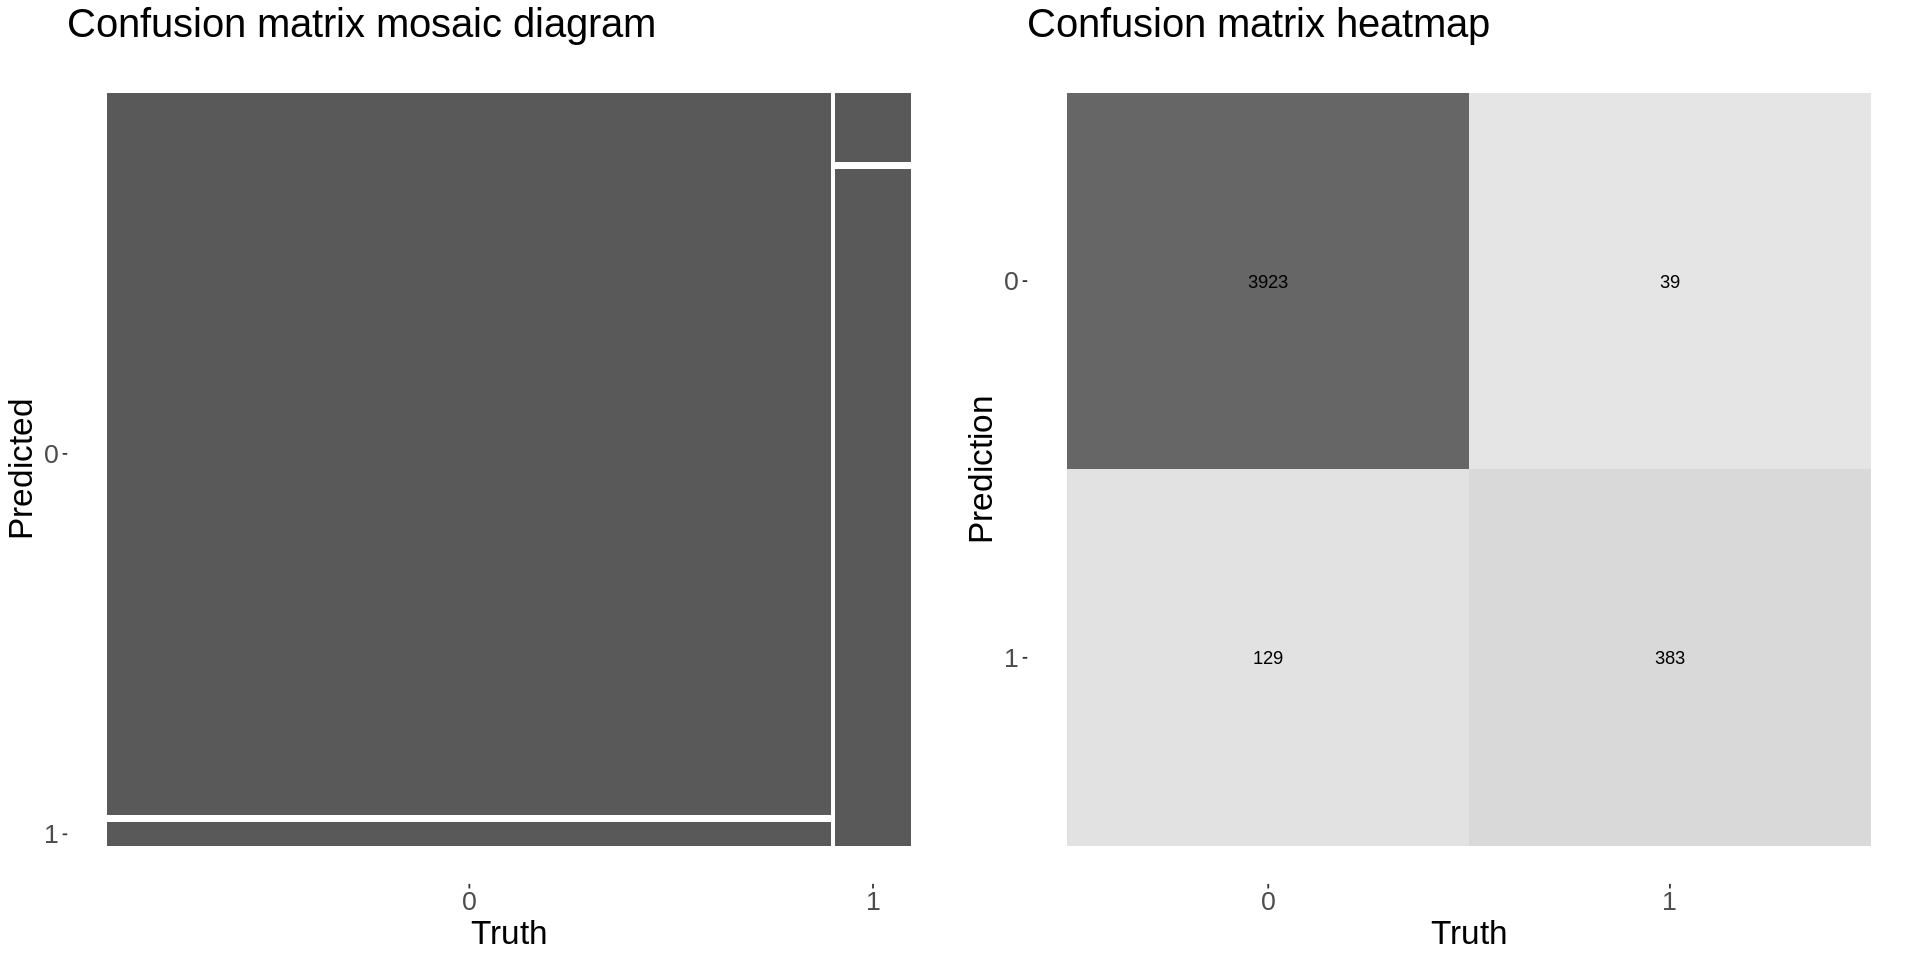

In [29]:
options(repr.plot.width = 16, repr.plot.height = 8)
mosaic <- autoplot(confusion, type = "mosaic") + theme(text = element_text(size = 20)) + ggtitle("Confusion matrix mosaic diagram")
heatmap <- autoplot(confusion, type = "heatmap") + theme(text = element_text(size = 20)) + ggtitle("Confusion matrix heatmap")
confusion_plots <- plot_grid(mosaic, heatmap)

'Figure 5. Mosaic diagram and heatmap of the confusion matrix for K = 101'
confusion_plots

Figure 5 is the visual representation of the confusion matrix. While the model is capable of correctly classifying pulsar observations to a certain degree, there remains plenty to be desired in its performance. In the context of our model’s usage scenario, assigning a greater emphasis on false positives and false negatives both have their merits. If we were to prioritize fewer false-negative predictions, although the set of ‘real’ predicted pulsars might have fake observations mixed in, we are also less likely to miss real observations. Similarly, if we were to prioritize fewer false-positive predictions, although we can be more confident that the ‘real’ predicted pulsars are real, we are also more likely to mislabel more real pulsars as spurious. Overall, the value placed on false negatives/positives will depend on whether the user of the model would prefer more pulsar candidates or more accurate predictions.  

Calculating the precision and recall measures, we get:  

$Precision = \frac{True~positive}{True~positive + False~positive} = \frac{383}{383 + 129} = 74.8\%$  

$Recall = \frac{True~positive}{True~positive + False~negative} = \frac{383}{383 + 39} = 90.76\%$  

Although precision has plenty of room for improvement, since around 25% of ‘real’ pulsar predictions are in fact spurious, we believe that our model performed to an acceptable degree according to the recall measure. The recall measure indicates that more than 90% of all real pulsars within the test dataset were correctly identified. 

# Discussion

In conclusion, we discovered that:
- Not all columns within the dataset are relevant predictors for KNN pulsar classification.
    - Using forward selection for predictor variable selection, we identified the irrelevant predictors—DM-SNR Skewness and DM-SNR Excess Kurtosis. This also matches our expectations from exploratory data analysis.
- K = 1 appeared to have the best performance during cross-validation, however, the model’s accuracy drops suddenly for K values greater than 1 and gradually increases for larger K. The accuracy measure stabilizes for K values greater than 100. 
    - This is within expectations since the dataset contains a large number of observations. In addition, due to possible overfitting, it is expected that the training accuracy would be higher at smaller K values, since the model will be more dependent on the data. 
- The overall accuracy of the model is high
    - This is expected due to the class imbalance within the dataset, since simply predicting spurious for all observations would yield an accuracy close to 90%.
- Based on precision and recall, our model can identify more than 90% of all real pulsar observations, however, around 25% of ‘real’ predictions are in fact spurious.
    - This is also expected since radio emissions signals are highly complex and extremely challenging to analyze. Since KNN is a relatively simple classification model, as well as the fact that we are only using a few statistics, we cannot expect the model to be perfectly accurate and precise.
    
Given the predictor variables, we can conclude that it is possible to predict and classify pulsar observations to a reasonable degree. However, due to its precision, we believe the model should only be used as a preliminary filter for pulsar observations. Since KNN is a relatively simple algorithm, it would be more practical to use the model to prune spurious observations from thousands of observations before investigating the likely candidates in great detail. Overall, we believe the classification is satisfactory for a simple model.

With these findings, the astronomy students will be able to make preliminary predictions on real vs. spurious pulsar observations. While not all predicted ‘real’ pulsars are real in actuality, the number of observations could be decreased by several orders of magnitude. With a smaller set of pulsar candidates, the students would then be able to use other methods of greater complexity to distinguish between real and spurious observations. 

Naturally, these findings could lead to several questions, for instance:
- Is it possible to extract other types of information besides the aforementioned predictors from radio emissions data?
- How do we create a more efficient and effective model than the current KNN model for pulsar classification?
- How do we improve the precision of our pulsar classifications?

# References

- R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.
- D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005. 
- Pulsar HTRU2 dataset from https://archive.ics.uci.edu/ml/datasets/HTRU2